In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import torch
from torch import nn, optim
import numpy
import h5py
import os
import sys
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import scipy
from data.synthetic_generator import syntheticMixture3D
from utils.training import train_mixture
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel

def get_param(model, show=True):
    para = model.get_model_param()
    
    if show:
        for p_k in para:
            print(p_k)
            print(para[p_k])
            print(10*'---')
    
    return para

# Mixture modelling

### Generetate Synthetic 3D dataset

In [3]:
sig1 = torch.diag(torch.tensor([1, 1e-3, 1e-3]))
sig2 = torch.eye(3) + 0.9 * (torch.ones(3) - torch.eye(3))
sig3 = torch.diag(torch.tensor([1e-3, 1, 1])) \
       + 0.9 * torch.tensor([[0, 0, 0], [0, 0, 1], [0, 1, 0]])

SIGMAs = torch.stack([sig1, sig2, sig3], dim=0)
#print(SIGMAs, '\n-----------')

PIs = [0.6, 0.2, 0.2]
NUM_P = 3000
synX, synX_cluster = syntheticMixture3D(pi=PIs, Sigmas=SIGMAs, num_points=NUM_P, as_array=False)

Simulate 3000 point from 3 of clusters


### Mixture Watson

In [16]:
# model init
model_dist = Watson
model = TorchMixtureModel(model_dist, K=3, dist_dim=3)

_ = get_param(model)

pi
tensor([0.4067, 0.2879, 0.3054])
------------------------------
mix_comp_0
{'mu': tensor([0.2423, 0.8288, 0.5044]), 'kappa': tensor([0.7623])}
------------------------------
mix_comp_1
{'mu': tensor([0.5535, 0.0242, 0.8325]), 'kappa': tensor([0.4939])}
------------------------------
mix_comp_2
{'mu': tensor([0.1356, 0.6981, 0.7030]), 'kappa': tensor([0.1104])}
------------------------------


### Waton Mixture best learning rate

In [17]:
eval_LR = np.arange(0.001, 1, 0.03)
print(eval_LR)

[0.001 0.031 0.061 0.091 0.121 0.151 0.181 0.211 0.241 0.271 0.301 0.331
 0.361 0.391 0.421 0.451 0.481 0.511 0.541 0.571 0.601 0.631 0.661 0.691
 0.721 0.751 0.781 0.811 0.841 0.871 0.901 0.931 0.961 0.991]


In [ ]:
int_epoch = 1500
LR_results = np.zeros((len(eval_LR),int_epoch))

for idx, LR in enumerate(tqdm(eval_LR)):
    model = TorchMixtureModel(model_dist, K=3, dist_dim=3) #New init of model
    Adam_optimizer = optim.Adam(model.parameters(), lr=LR)
    LR_results[idx] = train_mixture(model, data=synX, optimizer=Adam_optimizer, num_epoch=int_epoch, keep_bar=False)

    #print(f'Max LL: {-epoch_likelihood[-1]}')
    
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(LR_results.T)
plt.title('Learning rate - Watson - Synthetic3D')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(np.round(eval_LR, 3), ncol=2, bbox_to_anchor=(1.01, 1.05), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

In [19]:
argmin = np.argmin(LR_results[:,-1])
LR_results[:,-1]

array([6083.64648438, 2620.61230469, 2418.07275391, 2166.76806641,
       1909.70739746, 1761.5144043 , 1727.87329102, 1674.7052002 ,
       1639.33081055, 1601.31689453, 1589.08032227, 1577.49621582,
       1551.27746582, 1505.77319336, 1539.73815918, 1541.95080566,
       1542.90637207, 2441.78466797, 1514.234375  , 1494.58081055,
       1680.00549316, 1546.03295898, 1502.60229492, 1508.37695312,
       1486.03662109, 2387.65771484, 2227.06762695, 1666.8918457 ,
       1665.85656738, 1665.70910645, 2374.81152344, 2372.28344727,
       2368.56225586, 2373.43359375])

In [20]:
watson_best_likelihood = LR_results[argmin,-1]
watson_best_LR = eval_LR[argmin]
print(f'Max LL: {-watson_best_likelihood}')
print(f'Using learning rate: {watson_best_LR}')

Max LL: -1486.03662109375
Using learning rate: 0.721


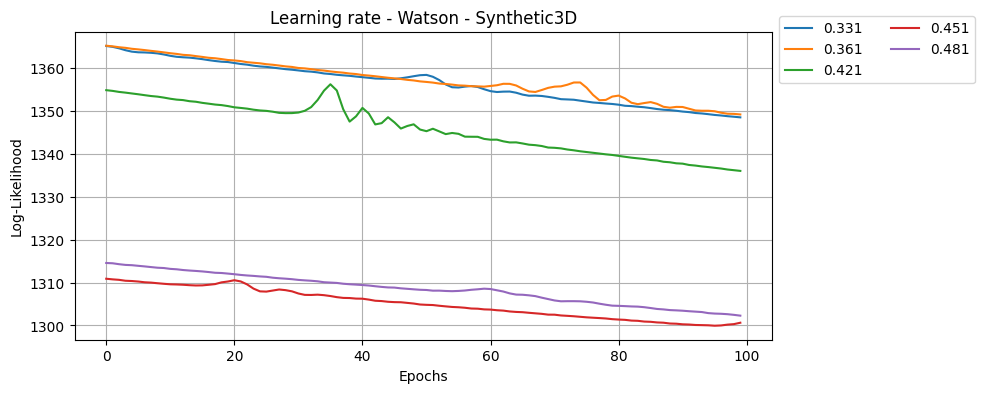

In [117]:
thr = 1 + 5/100 # procent from best LL
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(LR_results[LR_results[:,-1]<(thr*watson_best_likelihood),1400:].T)
plt.title('Learning rate - Watson - Synthetic3D')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(np.round(eval_LR[LR_results[:,-1]<(thr*watson_best_likelihood)], 3), ncol=2, bbox_to_anchor=(1.01, 1.05), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

## Mixture Watson with best lr

In [21]:
model = TorchMixtureModel(model_dist, K=3, dist_dim=3)
_ = get_param(model)

pi
tensor([0.2434, 0.4208, 0.3358])
------------------------------
mix_comp_0
{'mu': tensor([0.5271, 0.7999, 0.2870]), 'kappa': tensor([0.0228])}
------------------------------
mix_comp_1
{'mu': tensor([0.1689, 0.8888, 0.4260]), 'kappa': tensor([0.9815])}
------------------------------
mix_comp_2
{'mu': tensor([0.3455, 0.7710, 0.5350]), 'kappa': tensor([0.3738])}
------------------------------


In [22]:
Adam_optimizer = optim.Adam(model.parameters(), lr=0.451)
epoch_likelihood = train_mixture(model, data=synX, optimizer=Adam_optimizer, num_epoch=1500, keep_bar=False)

  0%|          | 0/1500 [00:00<?, ?it/s]

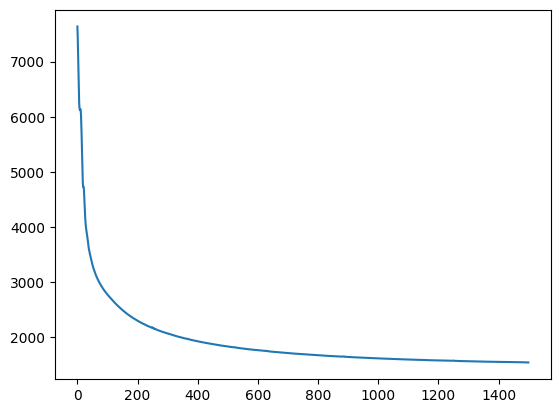

1539.99072265625
pi
tensor([0.5651, 0.4331, 0.0017])
------------------------------
mix_comp_0
{'mu': tensor([1.0000e+00, 9.3281e-04, 5.2106e-04]), 'kappa': tensor([127.0503])}
------------------------------
mix_comp_1
{'mu': tensor([0.5067, 0.6033, 0.6159]), 'kappa': tensor([2.6235])}
------------------------------
mix_comp_2
{'mu': tensor([0.0044, 0.7169, 0.6971]), 'kappa': tensor([52.9665])}
------------------------------


In [25]:
%matplotlib inline
plt.plot(epoch_likelihood)
plt.show()
print(epoch_likelihood[-1])
Watson_param = get_param(model)

## Plot of Synthetic | Learned Mixture Clusters from Parameters | Watson $\mu$ directions

<IPython.core.display.Javascript object>


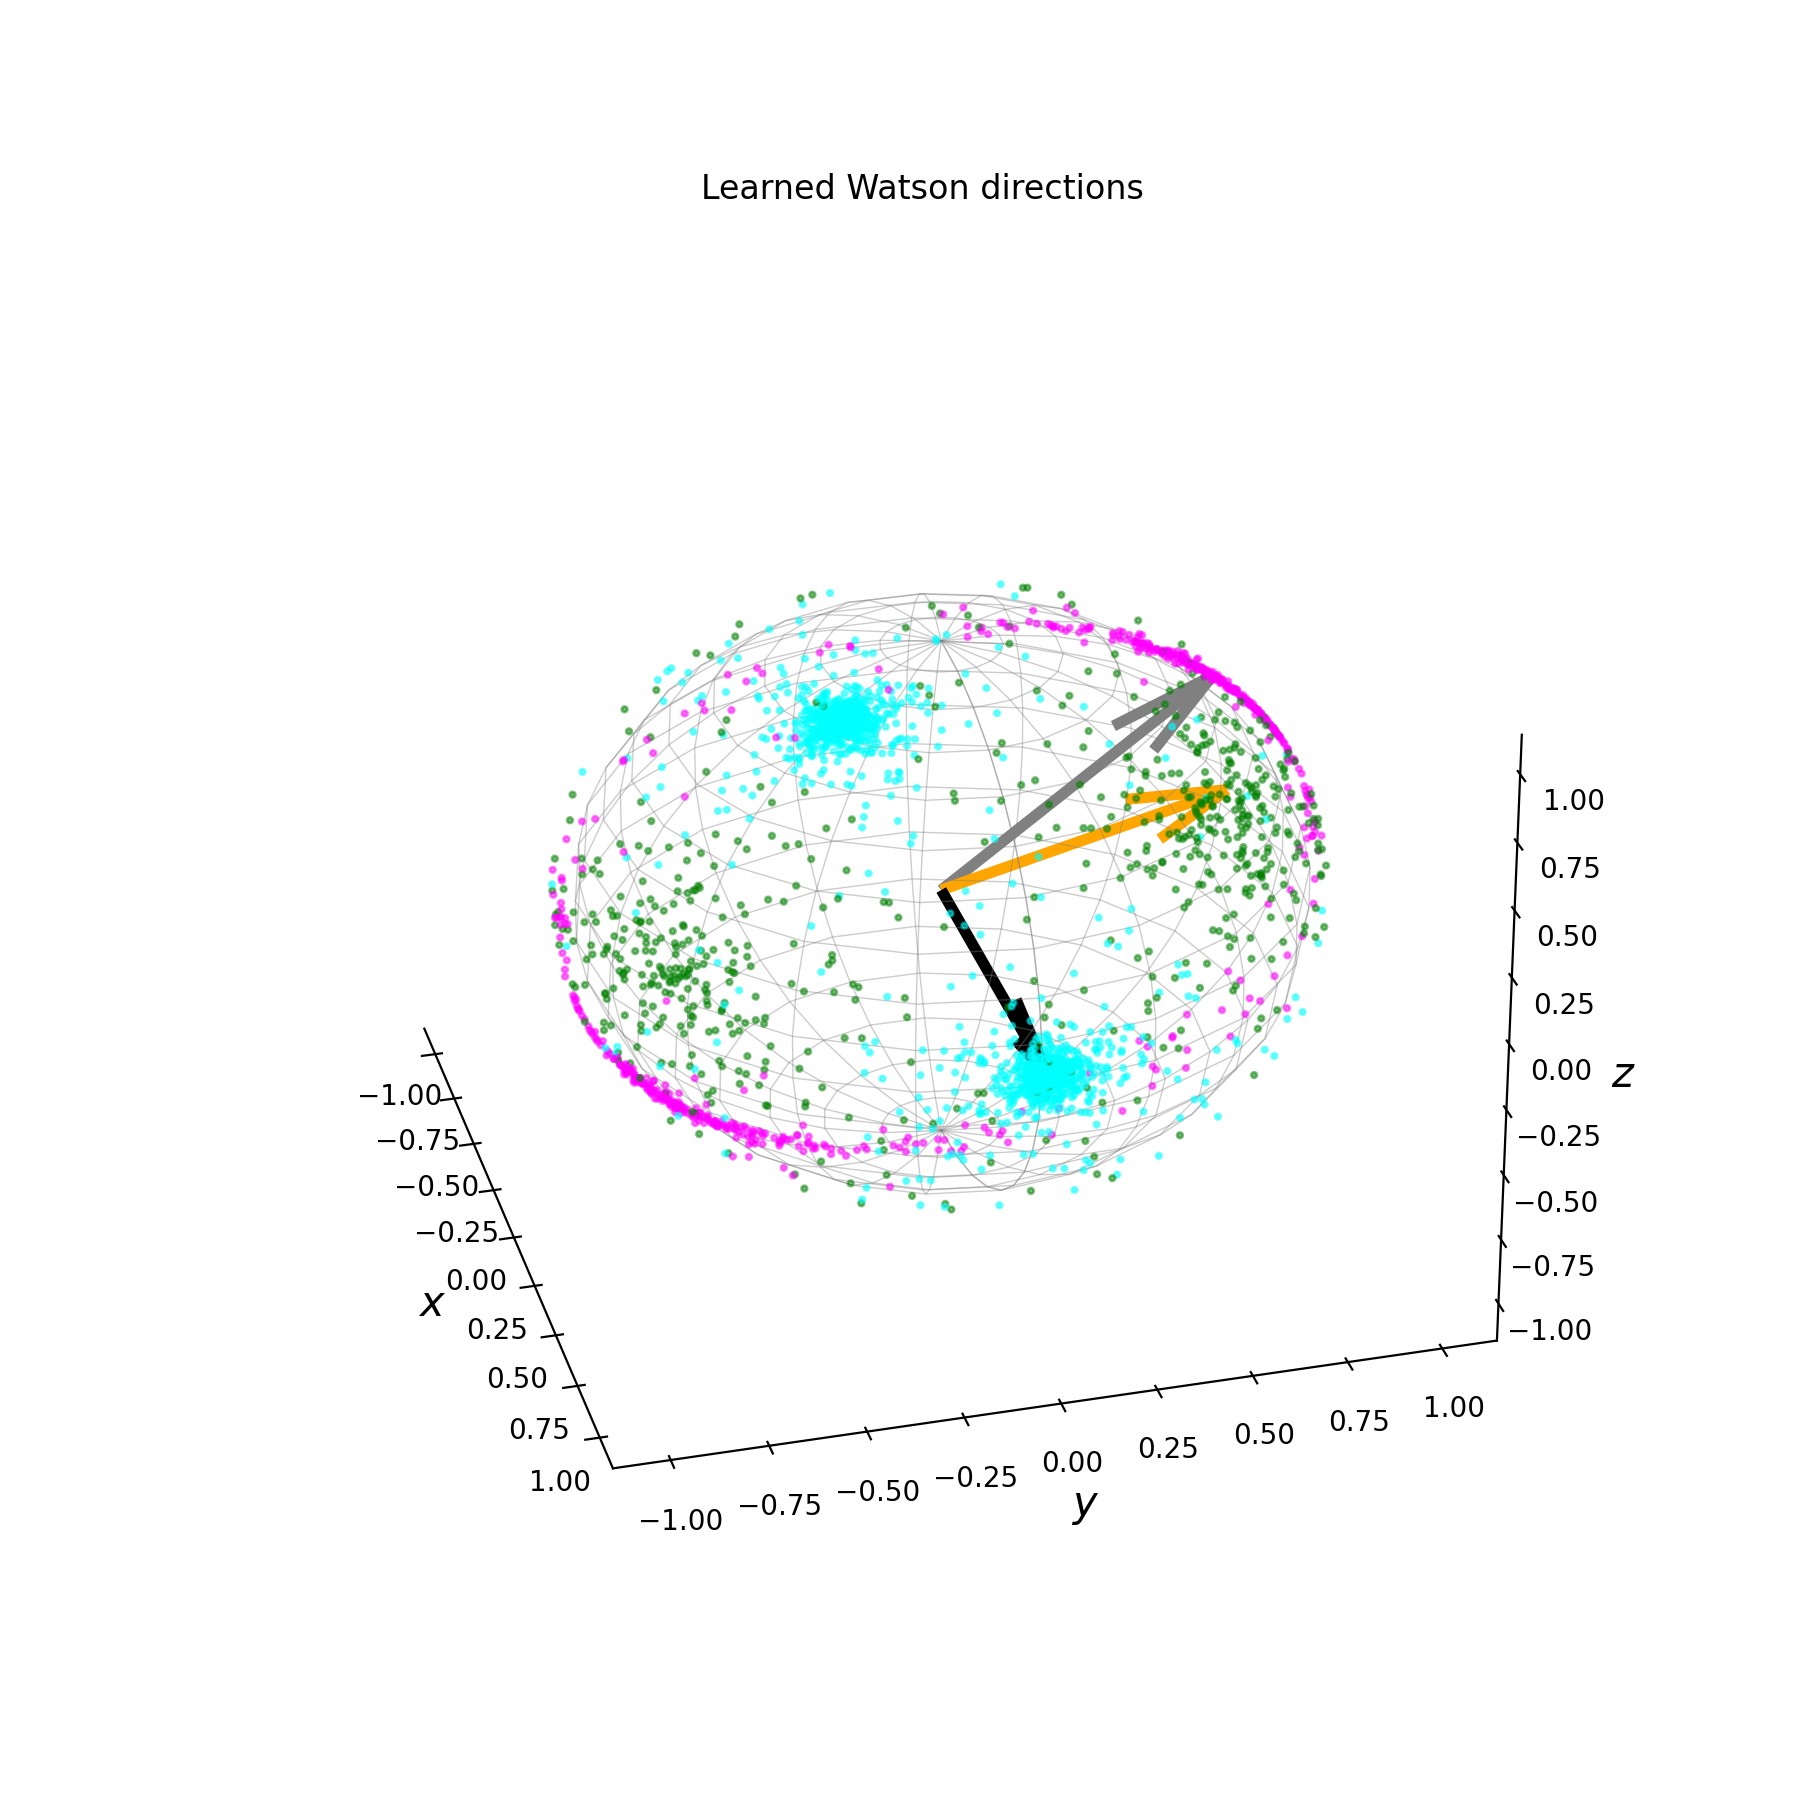

In [43]:
%matplotlib notebook
Watson_comps = [Watson_param[f'mix_comp_{idx}'] for idx in range(model.K)]
learned_pi = Watson_param['pi']


fig = plt.figure(figsize=(9,9))
id_2_color = {0: 'cyan', 1: 'green', 2: 'magenta'}

# Synthetic with Mean direction from watson
ax = fig.add_subplot(1, 1, 1, projection='3d')
label_color = [id_2_color[id] for id in np.array(synX_cluster)]
ax.scatter(synX[:, 0], synX[:, 1], synX[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title('Learned Watson directions')

# Background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)

x = .95 * np.outer(np.cos(u), np.sin(v))
y = .95 * np.outer(np.sin(u), np.sin(v))
z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)

# Watson Mu
vec_color = ['black', 'orange', 'grey']
for idx, w_param in enumerate(Watson_comps):
    mu_vec = np.array(w_param['mu'])
    kappa_p = w_param['kappa']
    ax.quiver(0, 0, 0, *mu_vec, linewidths=4., color = vec_color[idx])
ax.view_init(30, 135)
plt.show()

# Mixture  Angular Central Gaussian

In [47]:
# model init
model_dist = ACG
ACGmodel = TorchMixtureModel(model_dist, K=3, dist_dim=3)

_ = get_param(ACGmodel)

pi
tensor([0.3870, 0.3953, 0.2177])
------------------------------
mix_comp_0
tensor([[ 1.8598,  0.8070,  0.9131],
        [ 0.8070,  0.9625, -0.4162],
        [ 0.9131, -0.4162,  3.1967]])
------------------------------
mix_comp_1
tensor([[ 0.9135,  0.7465, -0.3850],
        [ 0.7465,  2.2947, -0.0695],
        [-0.3850, -0.0695,  0.8597]])
------------------------------
mix_comp_2
tensor([[ 1.3667,  1.5740,  1.3007],
        [ 1.5740,  3.0594, -0.4546],
        [ 1.3007, -0.4546,  6.2153]])
------------------------------


### Learning rate eval

In [59]:
eval_LR = np.arange(0.001, 1, 0.03)
print(eval_LR)

[0.001 0.031 0.061 0.091 0.121 0.151 0.181 0.211 0.241 0.271 0.301 0.331
 0.361 0.391 0.421 0.451 0.481 0.511 0.541 0.571 0.601 0.631 0.661 0.691
 0.721 0.751 0.781 0.811 0.841 0.871 0.901 0.931 0.961 0.991]


In [ ]:
int_epoch = 1500
ACG_LR_results = np.zeros((len(eval_LR),int_epoch))

for idx, LR in enumerate(tqdm(eval_LR)):
    ACG_model = TorchMixtureModel(model_dist, K=3, dist_dim=3) #New init of model
    Adam_optimizer = optim.Adam(ACG_model.parameters(), lr=LR)
    ACG_LR_results[idx] = train_mixture(ACG_model, data=synX, optimizer=Adam_optimizer, num_epoch=int_epoch, keep_bar=False)
    
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(ACG_LR_results.T)
plt.title('Learning rate - ACG - Synthetic3D')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(np.round(eval_LR, 3), ncol=2, bbox_to_anchor=(1.01, 1.05), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

In [150]:
argmin = np.argmin(ACG_LR_results[:,-1])
ACG_LR_results[:,-4:]

array([[2441.94360352, 2439.97143555, 2438.00268555, 2436.03637695],
       [ 537.22644043,  537.27416992,  536.93237305,  536.61761475],
       [ 536.5859375 ,  536.58605957,  536.58648682,  536.58587646],
       [1351.33776855, 1351.33544922, 1351.33422852, 1351.33251953],
       [1349.85998535, 1349.85864258, 1349.85656738, 1349.85498047],
       [1352.46374512, 1352.46044922, 1352.45703125, 1352.45349121],
       [1347.96179199, 1347.96081543, 1347.96069336, 1347.96044922],
       [1350.17443848, 1350.18505859, 1350.17004395, 1350.15429688],
       [1349.68408203, 1349.68383789, 1349.68286133, 1349.68261719],
       [1349.85546875, 1349.8527832 , 1349.84973145, 1349.84765625],
       [ 537.33178711,  536.75445557,  536.63537598,  536.89038086],
       [1350.63720703, 1350.63134766, 1350.62512207, 1350.61987305],
       [1347.96728516, 1347.9934082 , 1348.03979492, 1348.07531738],
       [1349.52966309, 1349.62414551, 1349.7890625 , 1350.07641602],
       [1349.25402832, 1349.249633

In [90]:
acg_best_likelihood = ACG_LR_results[argmin,-1]
acg_best_LR = eval_LR[argmin]
print(f'Max LL: {-acg_best_likelihood}')
print(f'Using learning rate: {acg_best_LR}')

Max LL: -536.5858764648438
Using learning rate: 0.061


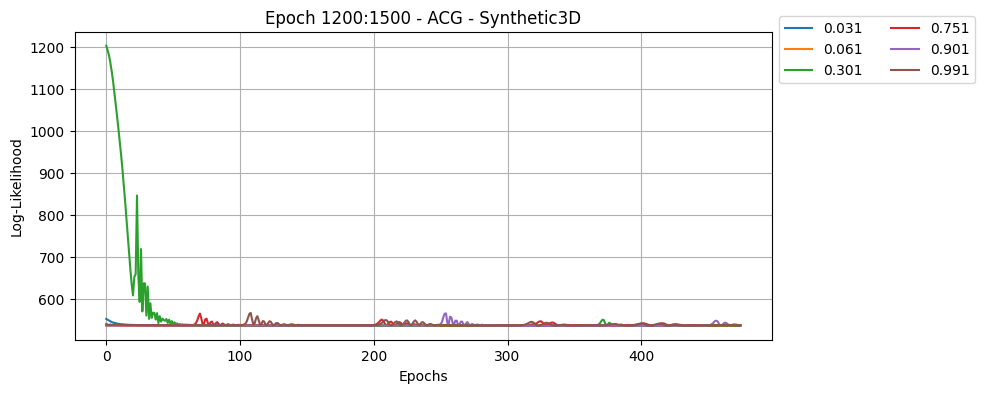

In [105]:
thr = 1 + 5/100 # procent from best LL
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(ACG_LR_results[ACG_LR_results[:,-1]<(thr*acg_best_likelihood),125:600].T)
plt.title('Epoch 1200:1500 - ACG - Synthetic3D')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(np.round(eval_LR[ACG_LR_results[:,-1]<(thr*acg_best_likelihood)], 3), ncol=2, bbox_to_anchor=(1.01, 1.05), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

### Train ACG with best LR

In [158]:
acgparam = get_param(ACG_model)

pi
tensor([0.3847, 0.1346, 0.1791])
------------------------------
mix_comp_0
tensor([[ 1.3835, -0.3499,  0.1578],
        [-0.3499,  1.6969,  1.4136],
        [ 0.1578,  1.4136,  2.2524]])
------------------------------
mix_comp_1
tensor([[ 0.7224, -0.1334,  0.5368],
        [-0.1334,  0.7724, -0.2064],
        [ 0.5368, -0.2064,  1.2690]])
------------------------------
mix_comp_2
tensor([[ 1.8346, -0.7052,  0.5209],
        [-0.7052,  1.2663,  0.4759],
        [ 0.5209,  0.4759,  1.6135]])
------------------------------


In [163]:
a = TorchMixtureModel(model_dist, K=3, dist_dim=3)
_ = get_param(a)

pi
tensor([0.9956, 0.2282, 0.2767])
------------------------------
mix_comp_0
tensor([[ 1.0342, -1.7515, -0.7967],
        [-1.7515,  4.3617,  1.5534],
        [-0.7967,  1.5534,  1.8012]])
------------------------------
mix_comp_1
tensor([[ 0.6340, -0.3374,  0.9818],
        [-0.3374,  1.1721, -3.1359],
        [ 0.9818, -3.1359,  9.5372]])
------------------------------
mix_comp_2
tensor([[ 0.7778, -0.3645, -2.0155],
        [-0.3645,  2.0024, -0.1000],
        [-2.0155, -0.1000,  7.3273]])
------------------------------


In [164]:
Adam_optimizer = optim.Adam(a.parameters(), lr=0.061)
epoch_likelihood = train_mixture(a, data=synX, optimizer=Adam_optimizer, num_epoch=400, keep_bar=False)

  0%|          | 0/400 [00:00<?, ?it/s]

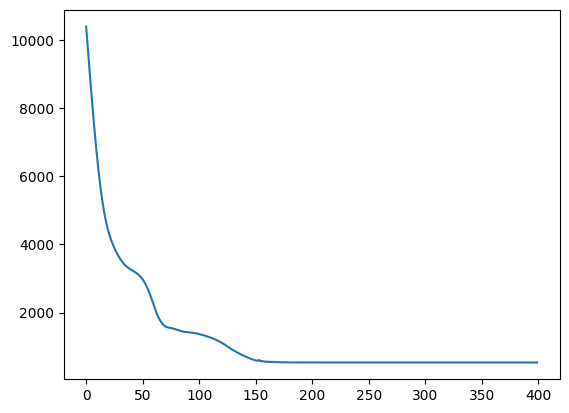

536.6486206054688
pi
tensor([ 1.1302, -0.6628, -0.9499])
------------------------------
mix_comp_0
tensor([[1.1933e+02, 3.5689e+00, 1.1796e-01],
        [3.5689e+00, 2.4520e-01, 1.1493e-03],
        [1.1796e-01, 1.1493e-03, 1.3409e-01]])
------------------------------
mix_comp_1
tensor([[0.2635, 0.1289, 0.5545],
        [0.1289, 0.4045, 0.9327],
        [0.5545, 0.9327, 4.0217]])
------------------------------
mix_comp_2
tensor([[7.7897e-02, 7.6069e-03, 2.8607e-03],
        [7.6069e-03, 1.7414e+01, 3.6516e+01],
        [2.8607e-03, 3.6516e+01, 1.6951e+02]])
------------------------------


In [166]:
plt.close()
%matplotlib inline
plt.plot(epoch_likelihood)
plt.show()
print(epoch_likelihood[-1])
best_acg_param = get_param(a)

## Plotting Learned Mixture ACG by new synthetic

In [175]:
print(best_acg_param)
learned_pi = scipy.special.softmax(best_acg_param['pi'], axis=0)
print(learned_pi)

{'pi': tensor([ 1.1302, -0.6628, -0.9499]), 'mix_comp_0': tensor([[1.1933e+02, 3.5689e+00, 1.1796e-01],
        [3.5689e+00, 2.4520e-01, 1.1493e-03],
        [1.1796e-01, 1.1493e-03, 1.3409e-01]]), 'mix_comp_1': tensor([[0.2635, 0.1289, 0.5545],
        [0.1289, 0.4045, 0.9327],
        [0.5545, 0.9327, 4.0217]]), 'mix_comp_2': tensor([[7.7897e-02, 7.6069e-03, 2.8607e-03],
        [7.6069e-03, 1.7414e+01, 3.6516e+01],
        [2.8607e-03, 3.6516e+01, 1.6951e+02]])}
[0.774352   0.12891002 0.09673802]


Simulate 3000 point from 3 of clusters


<IPython.core.display.Javascript object>


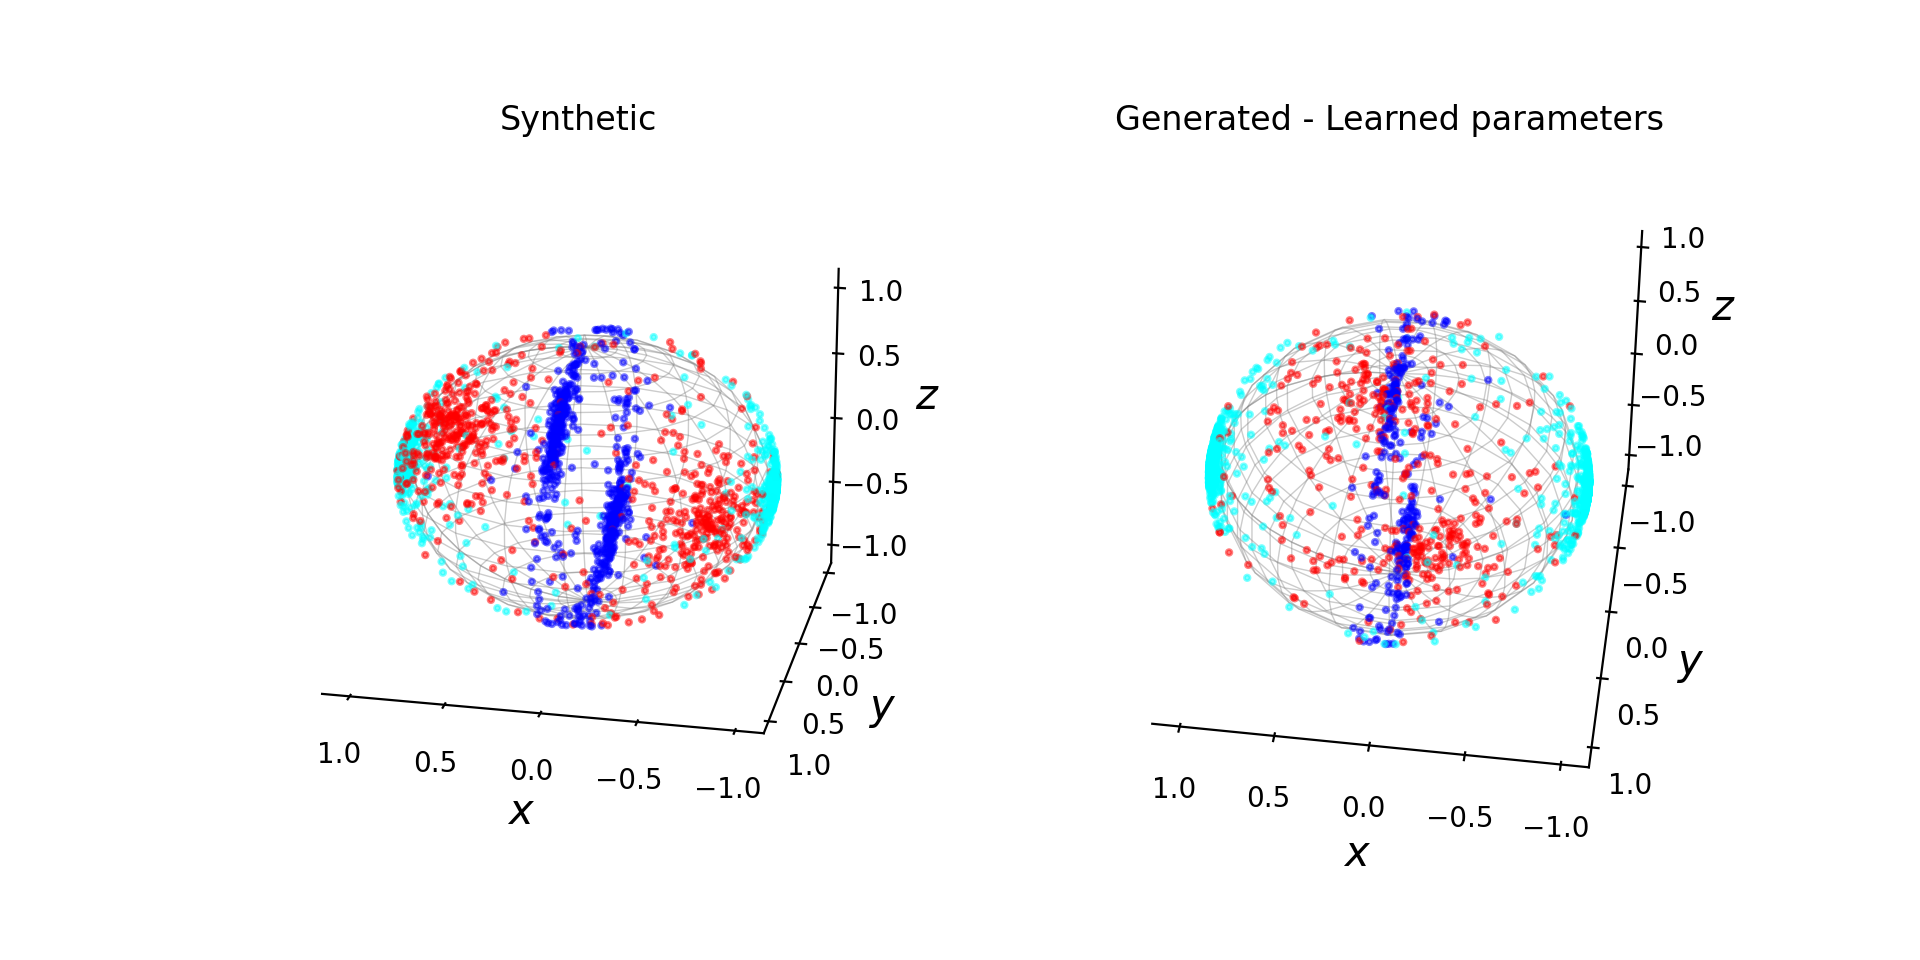

In [180]:
plt.close()
%matplotlib notebook
learned_sigma = torch.stack([best_acg_param[f'mix_comp_{idx}'] for idx in range(a.K)])

LearnX, Learn_cluster_id = syntheticMixture3D(pi=learned_pi, Sigmas=learned_sigma, num_points=3000, as_array=True)

fig = plt.figure(figsize=plt.figaspect(0.5))
id_2_color = {0: 'cyan', 1: 'red', 2: 'blue'}

# Synthetic
ax = fig.add_subplot(1, 2, 1, projection='3d')
label_color = [id_2_color[id] for id in np.array(synX_cluster)]
ax.scatter(synX[:, 0], synX[:, 1], synX[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title('Synthetic')

#Background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)

x = .95 * np.outer(np.cos(u), np.sin(v))
y = .95 * np.outer(np.sin(u), np.sin(v))
z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
ax.view_init(30, 135)

# Learned
ax = fig.add_subplot(1, 2, 2, projection='3d')
label_color = [id_2_color[id] for id in Learn_cluster_id]
ax.scatter(LearnX[:, 0], LearnX[:, 1], LearnX[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title('Generated - Learned parameters')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)

x = .95 * np.outer(np.cos(u), np.sin(v))
y = .95 * np.outer(np.sin(u), np.sin(v))
z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
ax.view_init(30, 135)
plt.show()

# Hidden Markov Model - Synthetic data

In [21]:
%matplotlib notebook
from data.synthetic_generator import syntheticMixture3D
from utils.training import train_mixture, train_hmm, train_hmm_subjects
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel
from models.HMM.HMM_torch import HiddenMarkovModel as HMM
from data.synthetic_generator import syntheticHMM
import scipy

Simulate sequence of length 150 from 3 hidden states


<IPython.core.display.Javascript object>


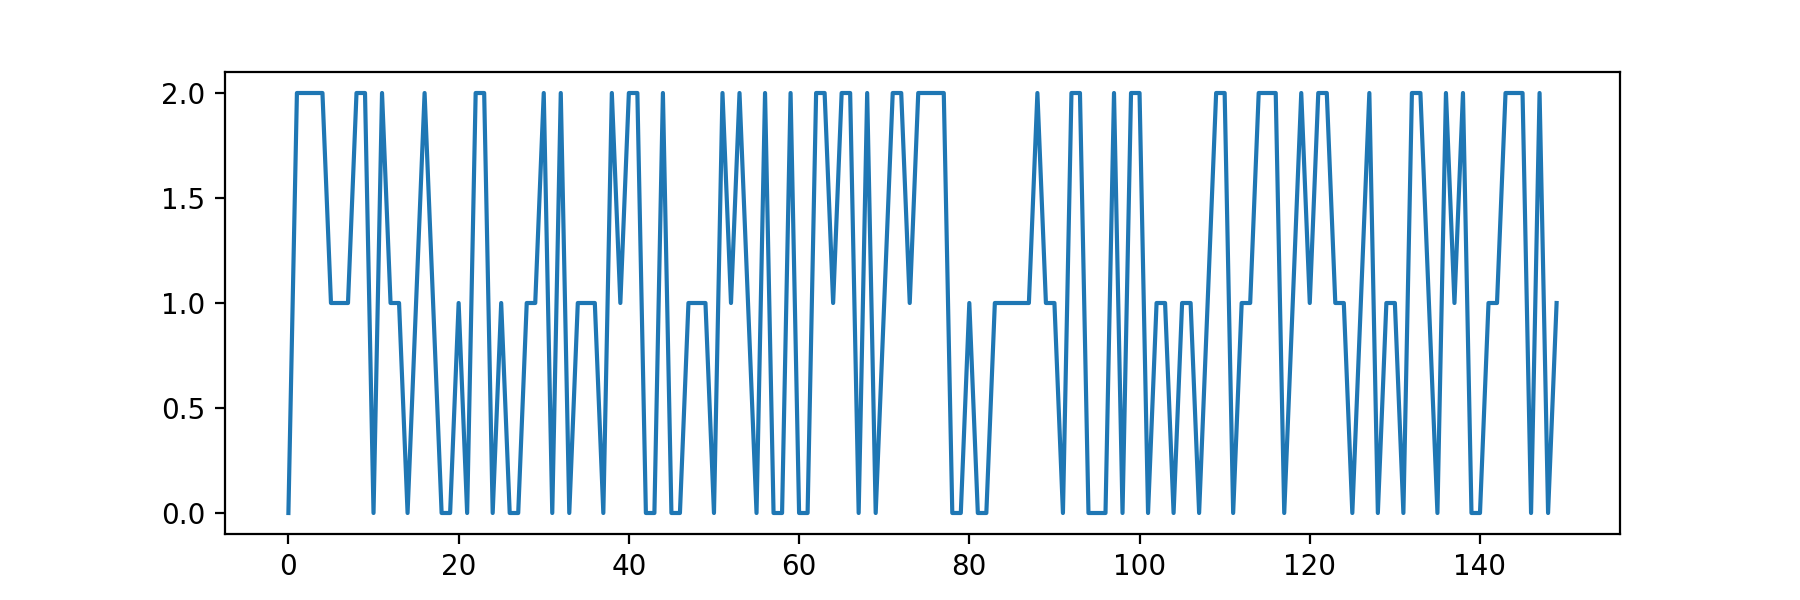

In [22]:
TRANSITION = torch.tensor([[0.4, 0.4, 0.2],
                          [0.2, 0.6, 0.2],
                          [0.4, 0.3, 0.3]])
PIs = [0.6, 0.2, 0.2]
synX_emission, Z_seq = syntheticHMM(pi=PIs, Sigmas=SIGMAs, transition_matrix=TRANSITION, seq_len=150, num_subject = 20)

fig = plt.figure(figsize=(9,3))
ax = fig.add_subplot(1,1,1)
ax.plot(Z_seq[0])
plt.show()

In [12]:
synX_emission.shape

torch.Size([20, 150, 3])

# Watson HMM on synthetic data

In [25]:
model_dist = Watson
model = HMM(num_states=3, observation_dim=3, emission_dist=model_dist)

_ = get_param(model)

un_norm_priors
tensor([0.6113, 0.0242, 0.4938])
------------------------------
un_norm_Transition_matrix
tensor([[0.6677, 0.4743, 0.5548],
        [0.5694, 0.7185, 0.8507],
        [0.9712, 0.5512, 0.8174]])
------------------------------
emission_model_0
{'mu': tensor([0.0819, 0.0956, 0.9920]), 'kappa': tensor([5.])}
------------------------------
emission_model_1
{'mu': tensor([0.3759, 0.5481, 0.7472]), 'kappa': tensor([3.])}
------------------------------
emission_model_2
{'mu': tensor([0.2928, 0.9447, 0.1478]), 'kappa': tensor([8.])}
------------------------------


In [26]:
hmm_eval_LR = np.arange(0.08, 1, 0.08)[4:5]
hmm_eval_LR = [0.25,0.65]
print(hmm_eval_LR)

[0.25, 0.65, 0.9]


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

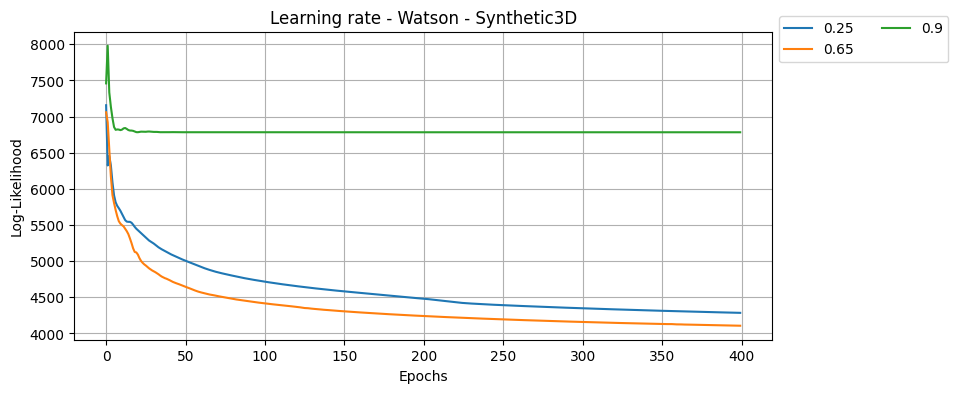

In [27]:
int_epoch = 400
watson_hmm_LR_results = np.zeros((len(hmm_eval_LR),int_epoch))

for idx, LR in enumerate(tqdm(hmm_eval_LR)):
    watson_hmm = HMM(num_states=3, observation_dim=3, emission_dist=model_dist) #New init of model
    Adam_optimizer = optim.Adam(watson_hmm.parameters(), lr=LR)
    watson_hmm_LR_results[idx] = train_hmm(watson_hmm, data=synX_emission, optimizer=Adam_optimizer, num_epoch=int_epoch, keep_bar=False)

    
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(watson_hmm_LR_results.T)
plt.title('Learning rate - Watson - Synthetic3D')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(np.round(hmm_eval_LR, 3), ncol=2, bbox_to_anchor=(1.01, 1.05), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

## Train model with best lr

In [28]:
model_dist = Watson
WBmodel = HMM(num_states=3, observation_dim=3, emission_dist=model_dist)

_ = get_param(WBmodel)

un_norm_priors
tensor([0.1078, 0.0186, 0.3688])
------------------------------
un_norm_Transition_matrix
tensor([[0.1452, 0.1755, 0.2677],
        [0.8078, 0.2394, 0.3043],
        [0.3015, 0.8530, 0.2664]])
------------------------------
emission_model_0
{'mu': tensor([0.5752, 0.4836, 0.6598]), 'kappa': tensor([8.])}
------------------------------
emission_model_1
{'mu': tensor([0.5175, 0.8547, 0.0413]), 'kappa': tensor([5.])}
------------------------------
emission_model_2
{'mu': tensor([0.7426, 0.3112, 0.5931]), 'kappa': tensor([4.])}
------------------------------


In [29]:
Adam_optimizer = optim.Adam(WBmodel.parameters(), lr=0.65)
wb_epoch_likelihood = train_hmm(WBmodel, data=synX_emission, optimizer=Adam_optimizer, num_epoch=1000, keep_bar=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

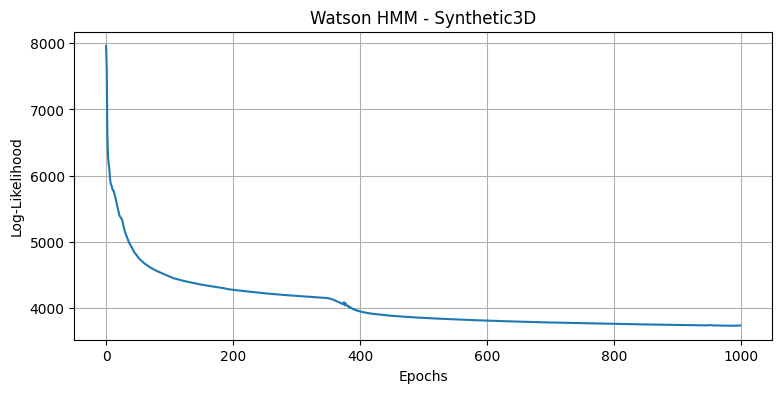

In [30]:
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(wb_epoch_likelihood)
plt.title('Watson HMM - Synthetic3D')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.grid()
plt.show()

In [104]:
print(wb_epoch_likelihood[-4:])

[3739.58496094 3740.51025391 3741.38745117 3742.02050781]


In [31]:
wb_param = get_param(WBmodel)

un_norm_priors
tensor([ 0.1578, -0.3109,  1.0063])
------------------------------
un_norm_Transition_matrix
tensor([[ 0.2803,  1.4164,  0.7479],
        [-0.5082,  1.1236,  0.2690],
        [-0.0614,  1.3545,  0.6797]])
------------------------------
emission_model_0
{'mu': tensor([0.0009, 0.7105, 0.7037]), 'kappa': tensor([56.6602])}
------------------------------
emission_model_1
{'mu': tensor([0.4799, 0.6209, 0.6198]), 'kappa': tensor([3.2025])}
------------------------------
emission_model_2
{'mu': tensor([ 1.0000, -0.0034, -0.0059]), 'kappa': tensor([122.2606])}
------------------------------


### Get parameter and Plotting

In [38]:
learned_mu = torch.stack([wb_param[f'emission_model_{idx}']['mu'] for idx in range(WBmodel.N)])
learned_pi = wb_param['un_norm_priors']
learned_pi = scipy.special.softmax(np.array(learned_pi),0)
print(torch.round(learned_mu, decimals=3))
print(learned_pi)

tensor([[ 0.0010,  0.7100,  0.7040],
        [ 0.4800,  0.6210,  0.6200],
        [ 1.0000, -0.0030, -0.0060]])
[0.2524039  0.15796328 0.58963287]


<IPython.core.display.Javascript object>


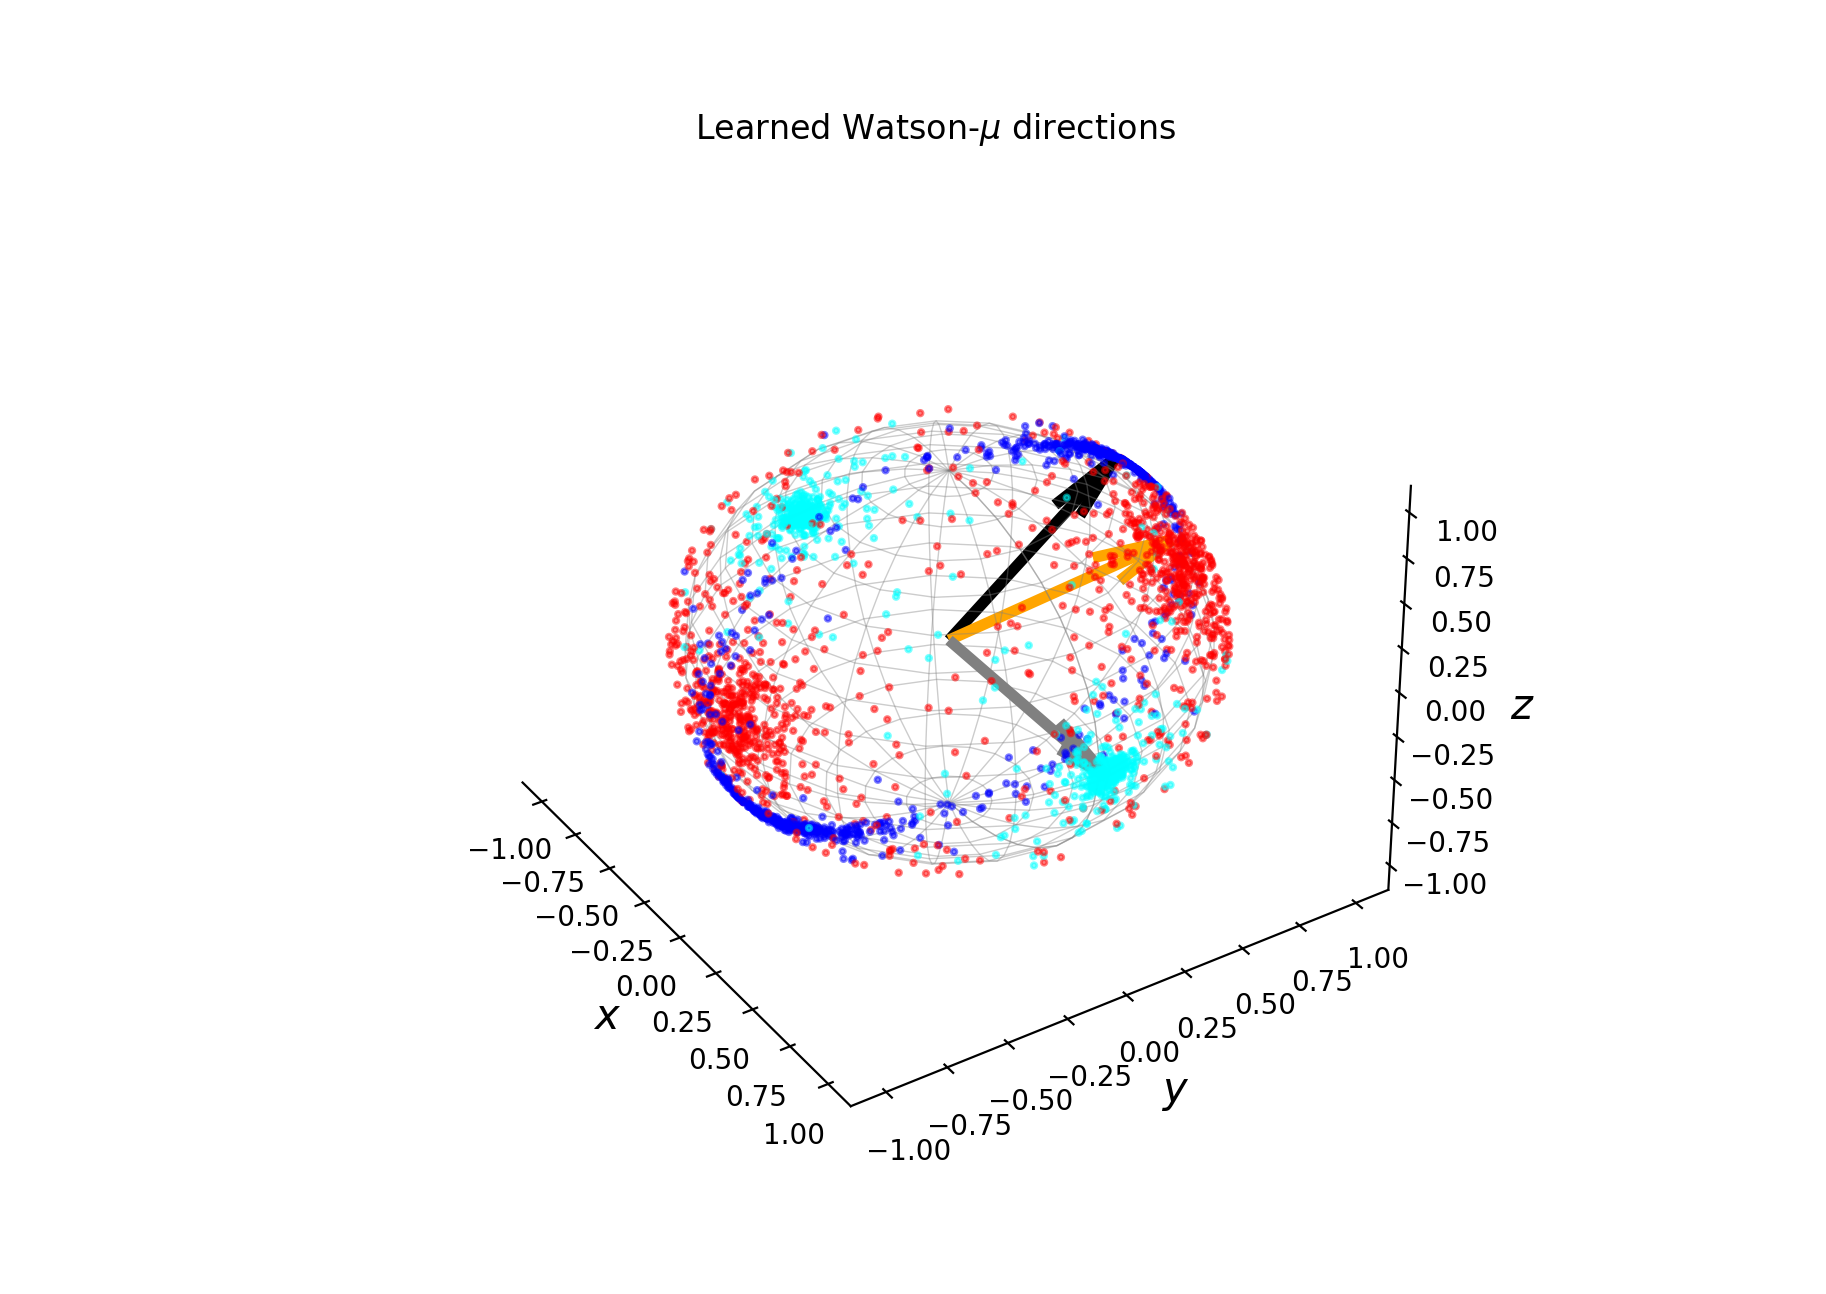

In [42]:
plt.close()
%matplotlib notebook
fig = plt.figure(figsize=plt.figaspect(1.))
# Synthetic GT (concate from batches of HMM synthetic)
X_gt_plot = torch.cat(tuple([*synX_emission]),0)
Z_seq_plot = torch.cat(tuple([*Z_seq]),0)

id_2_color = id_2_color = {0: 'cyan', 1: 'red', 2: 'blue'}

# Synthetic with Mean direction from watson
ax = fig.add_subplot(1, 1, 1, projection='3d')
label_color = [id_2_color[id] for id in np.array(Z_seq_plot)]
ax.scatter(X_gt_plot[:, 0], X_gt_plot[:, 1], X_gt_plot[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title(r'Learned Watson-$\mu$ directions')

# Background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)

x = .95 * np.outer(np.cos(u), np.sin(v))
y = .95 * np.outer(np.sin(u), np.sin(v))
z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)

# Watson Mu
vec_color = ['black', 'orange', 'grey']
for idx, mu in enumerate(learned_mu):
    ax.quiver(0, 0, 0, *mu, linewidths=4., color = vec_color[idx])
ax.view_init(30, 135)
plt.show()


## Viterbi decode - Watson

### OBSERVE CLUSTER SWITCH

In [43]:
# 0 -> 2
# 1 -> 1
# 2 -> 0
d = {'0':2,'2':0}

In [107]:
best_paths, paths_probs = WBmodel.viterbi2(synX_emission)

<IPython.core.display.Javascript object>


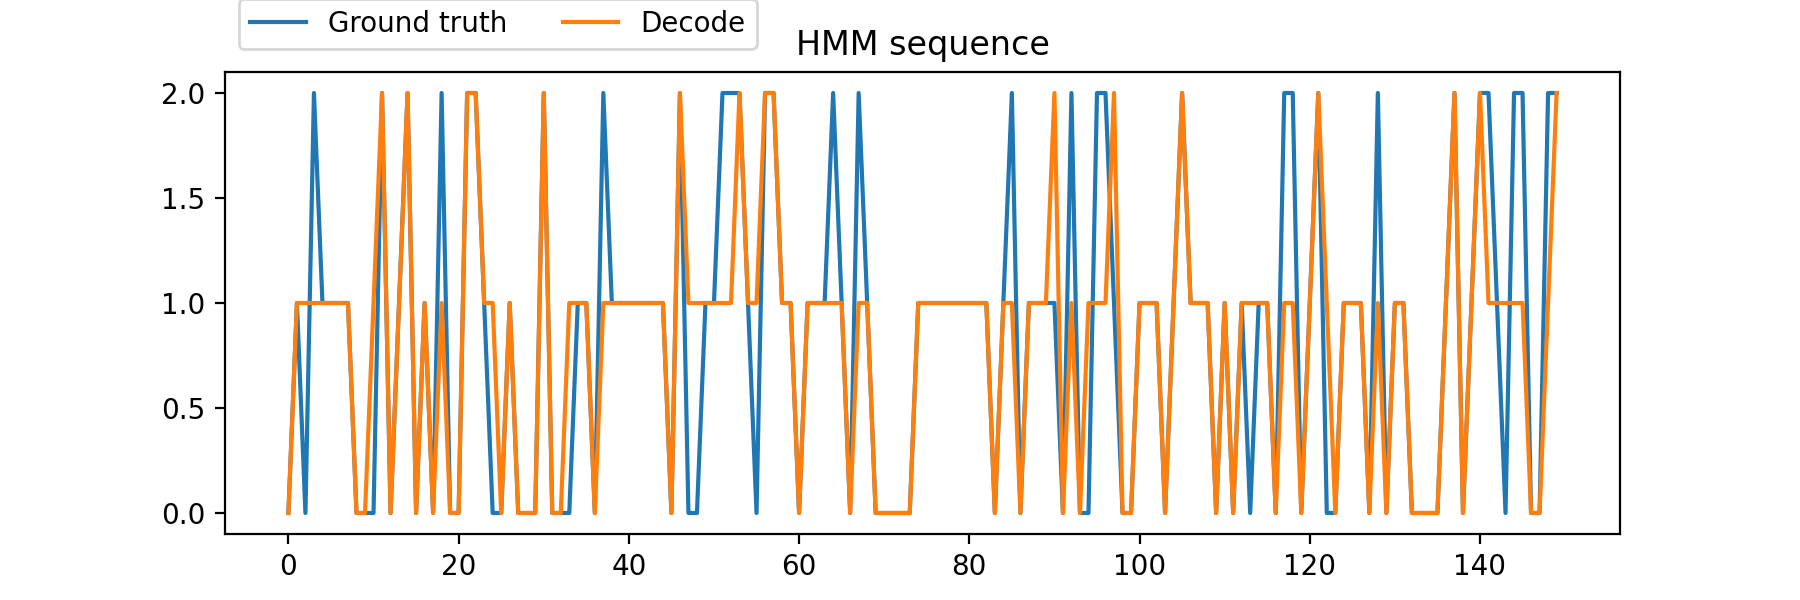

In [123]:
sub = 4
decode_path = list(best_paths[sub])
decode_path = [Z if Z == 1 else d[str(Z)] for Z in decode_path]
decode_path.insert(0,0) # shift correnction
plt.close()
fig, ax = plt.subplots(1,1, figsize=(9,3))

ax.plot(Z_seq[sub], label='Ground truth')
ax.plot(decode_path[:-1], label='Decode')
ax.set_title('HMM sequence')
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2)

plt.show()

### NMI metric

In [117]:
from sklearn.metrics import normalized_mutual_info_score as NMI

In [124]:
NMI(Z_seq[sub],decode_path[:-1])

0.5248946955117972

<IPython.core.display.Javascript object>


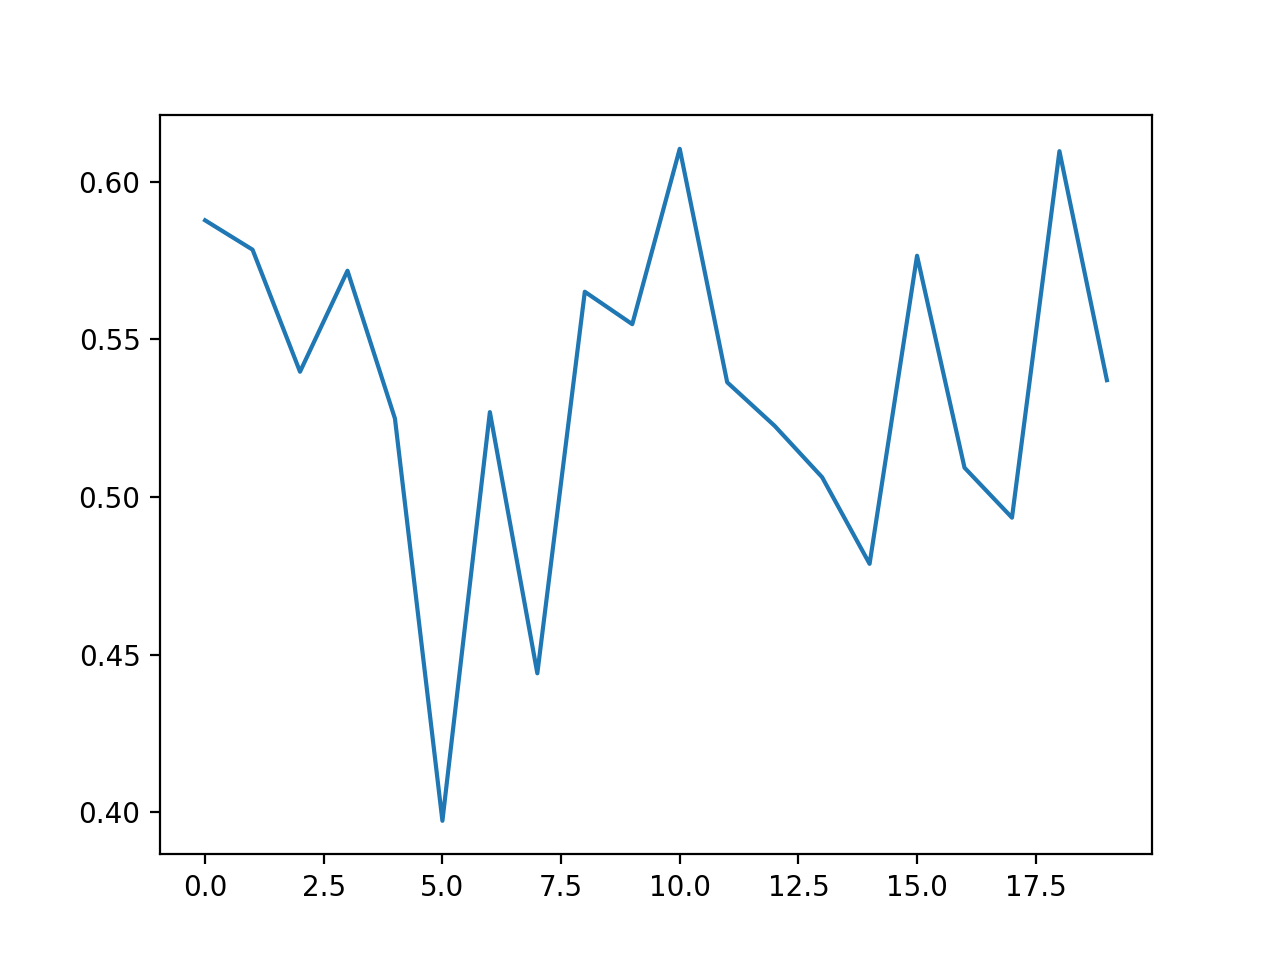

Average Watson NMI: 0.533576335840456


In [127]:
d = {'0':2,'2':0} 
running_NMI = []
for sub in range(len(best_paths)):
    decode_path = list(best_paths[sub])
    decode_path = [Z if Z == 1 else d[str(Z)] for Z in decode_path]
    decode_path.insert(0,0) # shift correnction
    
    gt = Z_seq[sub]
    
    sub_NMI = NMI(gt,decode_path[:-1])
    running_NMI.append(sub_NMI)
plt.close()
plt.plot(running_NMI)
plt.show()
print(f'Average Watson NMI: {np.mean(running_NMI)}')

# Viterbi Check with clone

### State mapping 

In [ ]:
# 0 cyan -> blue (2)
# 1 red -> red (1)
# 2 blue -> cyan(0)

# 0 -> 2
# 1 -> 1
# 2 -> 0

In [198]:
seq, prob = model.viterbi(X_emission)
print(seq[0])

tensor([[-17.9842,  -8.1262,  -3.4060],
        [ -6.0340,  -8.2784, -13.2517],
        [-19.6604, -10.4687,   0.8940],
        [-18.0112,  -4.5324,  -9.8509],
        [ -4.1476,  -9.7032, -13.4533],
        [ -9.0800,  -9.2217,  -4.2878],
        [-15.2546,  -8.7275,  -6.7781],
        [-19.7658, -10.0439,   6.0938],
        [-13.8443, -11.0043, -13.0444],
        [-19.2043,  -8.1468,  -4.3449],
        [-18.8679,  -9.7994,  -6.1719],
        [-11.8357,  -9.4951, -11.7030],
        [-18.2737,  -6.1931,  -2.5920],
        [-11.2511,  -9.6484,  -7.8317],
        [-19.7618,  -9.9133,   4.6200],
        [-17.8135,  -6.7276,  -5.0974],
        [-12.6580, -10.6412,  -3.7279],
        [  2.2430,  -8.1778, -13.3163],
        [ -5.4477,  -8.9163, -13.3502],
        [-19.7579, -10.1728,   4.0686]], grad_fn=<MaxBackward0>)
tensor([[-26.6871,  -9.0716,  -9.2899],
        [-15.7908, -12.7044,  -9.9741],
        [-18.6471, -13.9661,  -6.0180],
        [-27.6101,  -8.6345, -13.4420],
        [ -2.82

tensor([[-587.4482, -328.9915, -449.3682],
        [-571.9944, -357.8231, -427.9275],
        [-621.7134, -335.2703, -416.8853],
        [-610.0110, -333.0246, -471.5958],
        [-550.2216, -334.7655, -446.7436],
        [-614.7280, -354.6823, -338.6452],
        [-554.1705, -335.9559, -468.3114],
        [-624.0741, -340.5427, -425.7784],
        [-655.6614, -343.3450, -384.7222],
        [-588.2267, -333.6147, -414.7456],
        [-637.7292, -360.3190, -360.8164],
        [-656.5120, -349.0400, -398.4779],
        [-652.9289, -320.4958, -402.3886],
        [-560.2823, -349.4263, -481.0915],
        [-640.0175, -348.3220, -374.9119],
        [-597.1561, -325.3609, -497.7302],
        [-495.6806, -341.3612, -450.5104],
        [-553.6458, -306.6271, -490.7043],
        [-575.1136, -341.5354, -410.6773],
        [-634.8261, -315.8819, -470.7615]], grad_fn=<MaxBackward0>)
tensor([[-595.7319, -329.6194, -455.5754],
        [-570.8707, -361.3154, -434.8400],
        [-623.4128, -338.9679

In [158]:
import copy

In [159]:
test_model = copy.deepcopy(model)

In [202]:
test_model.emission_models_forward(X_emission[:,0,:])[:,0]

tensor([-8.6813, -3.6679,  3.5139], grad_fn=<SelectBackward0>)

In [207]:
test_model.emission_models[1](X_emission[0,0].unsqueeze(dim=0))

tensor([-3.6679], grad_fn=<SubBackward0>)

In [379]:
ld = test_model.viterbi2(X_emission)
d = {'0':2,'2':0}
ld = [Z if Z == 1 else d[str(Z)] for Z in ld]
ld.insert(0,0)

<IPython.core.display.Javascript object>


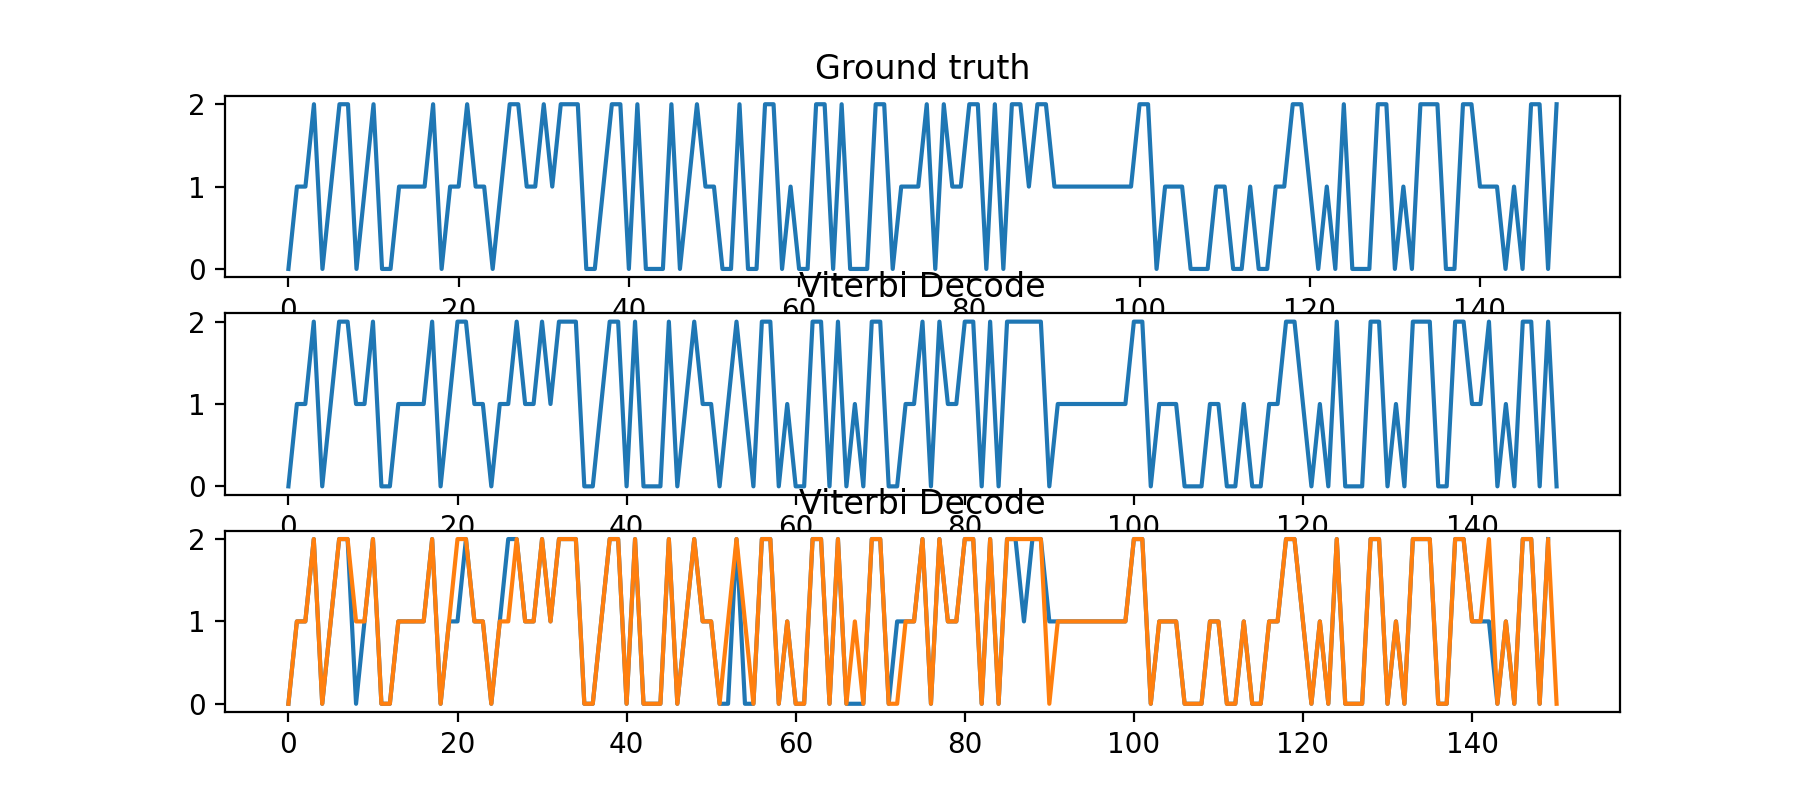

In [380]:
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(3,1,1)
ax.set_title('Ground truth')
ax.plot(Z_seq[0])

ax = fig.add_subplot(3,1,2)
ax.plot(ld)
ax.set_title('Viterbi Decode')

ax = fig.add_subplot(3,1,3)
ax.plot(np.array(Z_seq[0]))
ax.plot(ld)
ax.set_title('Viterbi Decode')

plt.show()

In [370]:
np.array(Z_seq[0]) - ld

array([-1,  0, -1,  2, -1, -1,  0,  1, -1, -1,  2,  0, -1,  0,  0,  0, -1,
        2, -1, -1, -1,  1,  0,  1, -1,  0,  0,  1,  0, -1,  1, -1,  0,  0,
        2,  0, -1, -1,  0,  2, -2,  2,  0,  0, -2,  2, -1, -1,  1,  0,  1,
       -1, -2,  1,  0, -2,  0,  2, -1,  1,  0, -2,  0,  2, -2,  2, -1,  0,
       -2,  0,  2,  0,  0,  0, -1,  2, -2,  1,  0, -1,  0,  2, -2,  2, -2,
        0,  0, -1,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  2,
       -1,  0,  0,  1,  0,  0, -1,  0,  1,  0, -1,  1,  0, -1,  0, -1,  0,
        1,  1, -1,  1, -2,  2,  0,  0, -2,  0,  2, -1,  1, -2,  0,  0,  2,
        0, -2,  0,  1,  0, -1,  1, -1,  1, -2,  0,  2, -2,  2])

In [352]:
list(range(10 - 2, -1, -1))

[8, 7, 6, 5, 4, 3, 2, 1, 0]

In [161]:
test_model.transition_matrix.data.softmax(dim=1)

tensor([[0.3415, 0.3269, 0.3317],
        [0.2769, 0.4501, 0.2729],
        [0.3127, 0.3630, 0.3243]])

In [163]:
test_Transition = torch.tensor([[0.2, 0.4, 0.4],
                          [0.2, 0.6, 0.2],
                          [0.3, 0.3, 0.4]])

In [189]:
test_model.transition_matrix = torch.nn.Parameter(test_Transition)
test_model.state_priors = torch.nn.Parameter(torch.tensor([0.2,0.2,0.6]))
optim_seq, optim_path_probs = model.viterbi2(X_emission, external_eval=True)
optim_seq[0]

23

In [167]:
test_param = get_param(test_model)

un_norm_priors
tensor([0.2000, 0.2000, 0.6000])
------------------------------
un_norm_Transition_matrix
tensor([[0.2000, 0.4000, 0.4000],
        [0.2000, 0.6000, 0.2000],
        [0.3000, 0.3000, 0.4000]])
------------------------------
emission_model_0
tensor([[ 7.7739e-02,  3.1716e-03, -2.0065e-03],
        [ 3.1716e-03,  1.6838e+01,  3.1824e+01],
        [-2.0065e-03,  3.1824e+01,  1.3920e+02]])
------------------------------
emission_model_1
tensor([[ 0.5939,  0.3365,  1.3631],
        [ 0.3365,  0.9666,  2.3316],
        [ 1.3631,  2.3316, 10.2959]])
------------------------------
emission_model_2
tensor([[ 1.0518e+02, -1.0077e+00,  9.0111e+00],
        [-1.0077e+00,  1.1578e-01, -8.0832e-02],
        [ 9.0111e+00, -8.0832e-02,  8.8190e-01]])
------------------------------


In [181]:
test_sigma = torch.stack([param[f'emission_model_{idx}'] for idx in range(test_model.N)])

In [182]:
test_sigma

tensor([[[ 7.7739e-02,  3.1716e-03, -2.0065e-03],
         [ 3.1716e-03,  1.6838e+01,  3.1824e+01],
         [-2.0065e-03,  3.1824e+01,  1.3920e+02]],

        [[ 5.9391e-01,  3.3652e-01,  1.3631e+00],
         [ 3.3652e-01,  9.6659e-01,  2.3316e+00],
         [ 1.3631e+00,  2.3316e+00,  1.0296e+01]],

        [[ 1.0518e+02, -1.0077e+00,  9.0111e+00],
         [-1.0077e+00,  1.1578e-01, -8.0832e-02],
         [ 9.0111e+00, -8.0832e-02,  8.8190e-01]]])

Simulate 3000 point from 3 of clusters


<IPython.core.display.Javascript object>


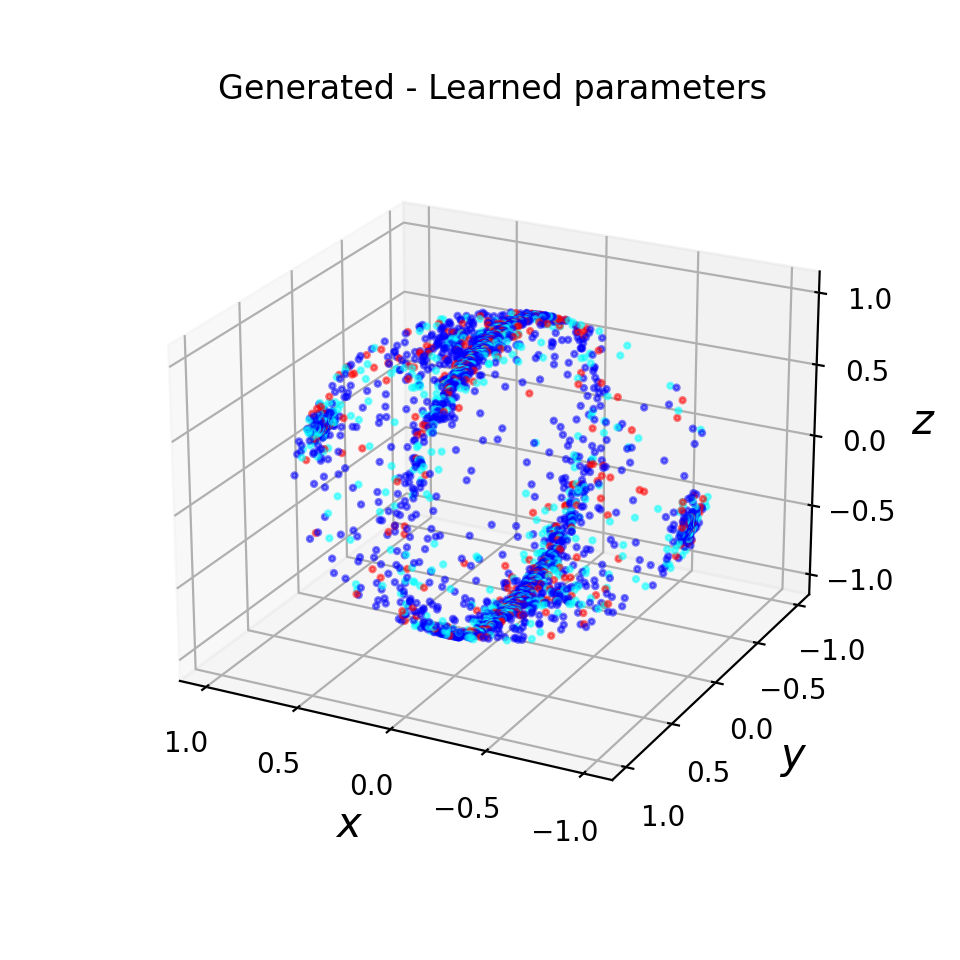

In [185]:
# softmax in syn generation

testX, test_cluster_id = syntheticMixture3D(pi=np.array([0.6,0.2,0.2]),Sigmas=test_sigma, num_points=3000, as_array=True)

fig = plt.figure(figsize=plt.figaspect(1.0))
id_2_color = {0: 'cyan', 1: 'red', 2: 'blue'}

# Learned
ax = fig.add_subplot(1, 1, 1, projection='3d')
label_color = [id_2_color[id] for id in Learn_cluster_id]
ax.scatter(testX[:, 0], testX[:, 1], testX[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title('Generated - Learned parameters')
ax.view_init(30, 135)
plt.show()

# ACG-HMM | Synthetic3D

In [ ]:
learned_sigma = torch.stack([wb_param[f'emission_model_{idx}'] for idx in range(WBmodel.N)])
learned_pi = wb_param['un_norm_priors']
learned_pi = scipy.special.softmax(np.array(learned_pi),0)
print(learned_pi)

# Mixture Model on FMRI data

In [119]:
import torch
from torch import nn, optim
import numpy
import h5py
import os
import sys
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
sys.path.append(os.path.abspath(os.path.join('..')))
from data.synthetic_generator import syntheticMixture3D
from utils.training import train_mixture, train_mixture_subjects
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel
%matplotlib notebook
fmri_dataset = '../data/dataset/dataset_all_subjects_LEiDA.hdf5'

### Loading data

In [120]:
dataf = h5py.File(fmri_dataset, mode='r')

num_subjects = len(list(dataf.keys()))
seq_len = 330
obs_dim = 90
bold_data = torch.zeros(num_subjects,seq_len,obs_dim)

bold_mixture = torch.zeros(num_subjects*seq_len,obs_dim)

for idx, subject in enumerate(list(dataf.keys())):
    bold_data[idx] = torch.tensor(np.array(dataf[subject]))
    

print(bold_data.shape)

torch.Size([199, 330, 90])


### Watson Mixture on Bold

100%|█| 100/100 [01:51<00:00,  1.12s/i


<IPython.core.display.Javascript object>


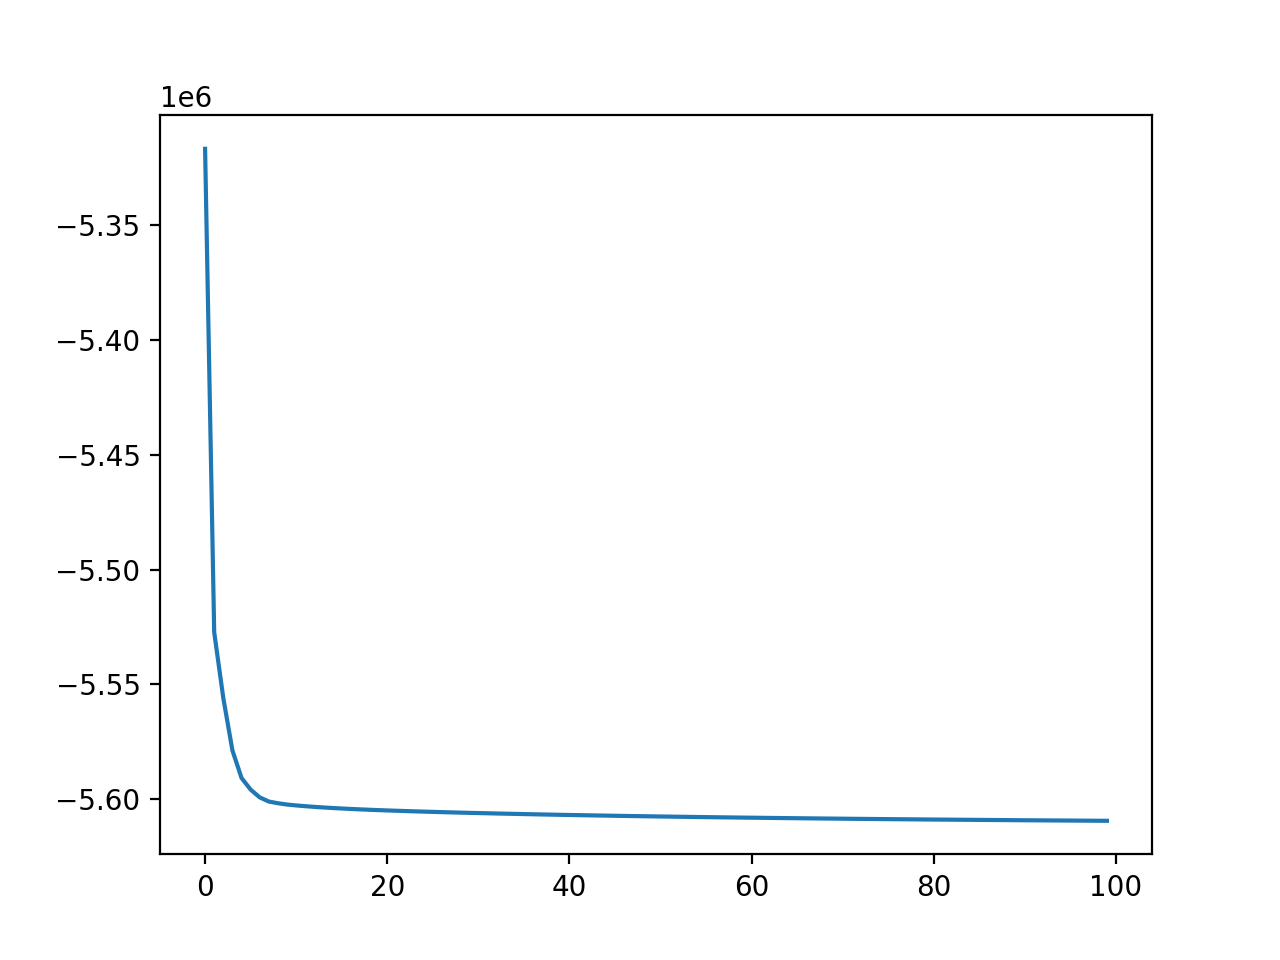

In [111]:
model_dist = Watson
model = TorchMixtureModel(model_dist, K=6, dist_dim=obs_dim)

#_ = get_param(model)

Adam_optimizer = optim.Adam(model.parameters(), lr=0.8)

epoch_likelihood = train_mixture_subjects(model, data=bold_data, optimizer=Adam_optimizer, num_epoch=100)

#_ = get_param(model)

plt.plot(epoch_likelihood)
plt.show()

### ACG mixture on bold

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:13<00:00,  1.93s/it]

pi
tensor([7.9358e-12, 2.4888e-11, 1.0000e+00])
------------------------------
mix_comp_0
tensor([[ 1.3052e-02,  7.4295e-03,  3.2562e-03,  ..., -4.5964e-01,
          1.6686e-01,  3.4042e-01],
        [ 7.4281e-03,  1.5806e-02,  1.1477e-03,  ...,  6.1178e-01,
         -1.6341e-01, -3.2488e-01],
        [ 3.2565e-03,  1.1477e-03,  1.2229e-02,  ...,  7.5526e-02,
         -8.6031e-02, -1.8863e-01],
        ...,
        [-4.5958e-01,  6.1065e-01,  7.5379e-02,  ...,  4.4412e+02,
         -1.5383e+02, -3.1832e+02],
        [ 1.6689e-01, -1.6311e-01, -8.6005e-02,  ..., -1.5391e+02,
          6.1053e+01,  1.2539e+02],
        [ 3.4038e-01, -3.2411e-01, -1.8855e-01,  ..., -3.1838e+02,
          1.2535e+02,  2.6143e+02]])
------------------------------
mix_comp_1
tensor([[ 8.6231e-03, -1.5156e-03, -4.7035e-03,  ...,  5.5767e-01,
         -1.3543e-01,  8.6355e-01],
        [-1.5148e-03,  8.7384e-03, -1.5249e-03,  ..., -2.2927e-01,
          7.1283e-02, -3.5464e-01],
        [-4.7049e-03, -1.5238e

<IPython.core.display.Javascript object>


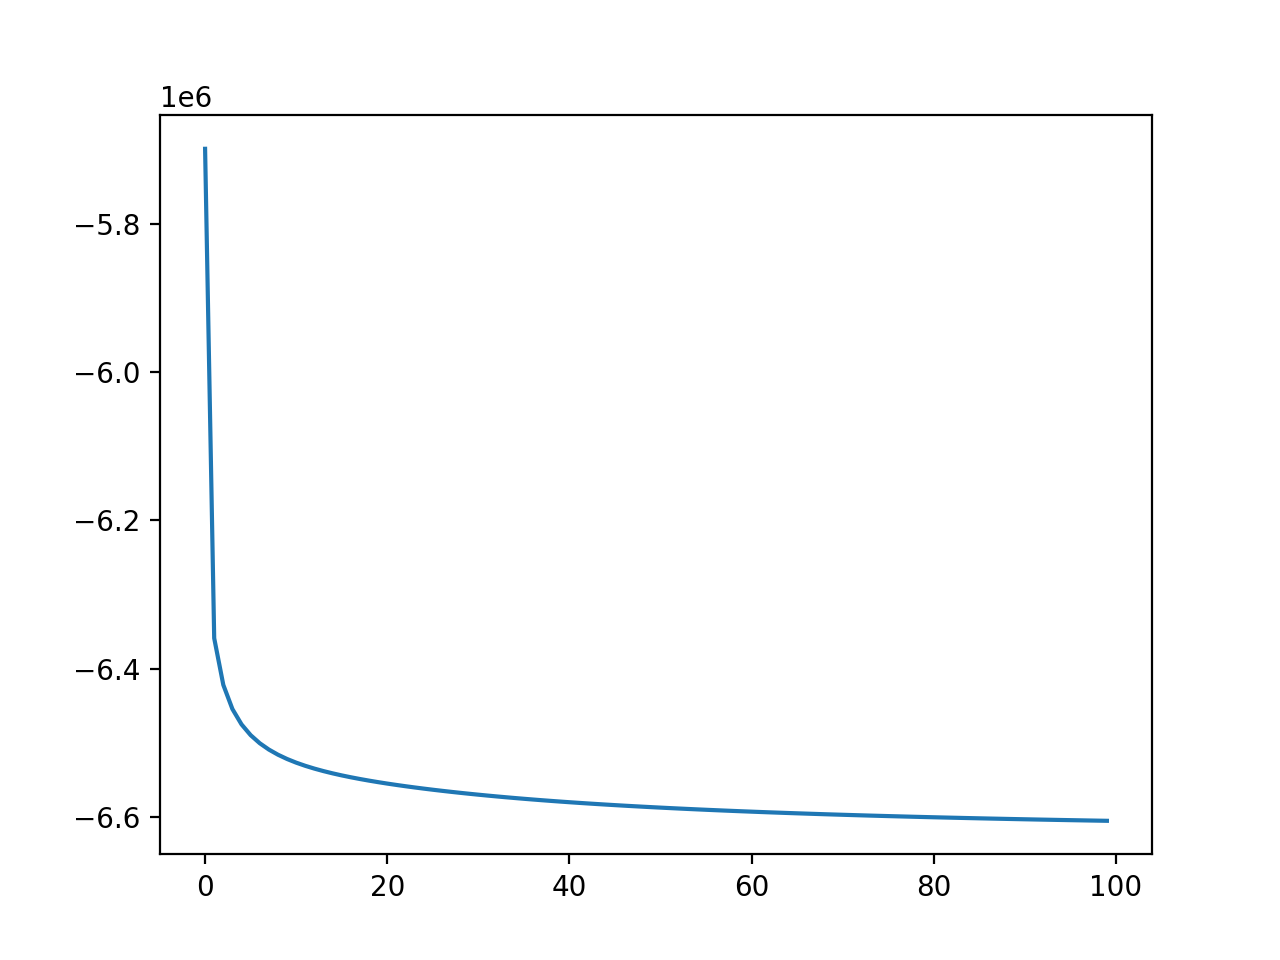

In [122]:
model_dist = ACG
model = TorchMixtureModel(model_dist, K=3, dist_dim=obs_dim)

#_ = get_param(model)

Adam_optimizer = optim.Adam(model.parameters(), lr=0.8)

epoch_likelihood = train_mixture_subjects(model, data=bold_data, optimizer=Adam_optimizer, num_epoch=100)

_ = get_param(model)

plt.plot(epoch_likelihood)
plt.show()

In [125]:
epoch_likelihood

array([-5699293.5, -6358720.5, -6421632. , -6454204. , -6474850. ,
       -6489356. , -6500234.5, -6508771. , -6515702.5, -6521484. ,
       -6526413.5, -6530686. , -6534450.5, -6537806. , -6540830.5,
       -6543589. , -6546118.5, -6548461.5, -6550643. , -6552690.5,
       -6554617.5, -6556442. , -6558172. , -6559822.5, -6561395. ,
       -6562902.5, -6564346. , -6565731. , -6567063.5, -6568342. ,
       -6569578. , -6570764.5, -6571909. , -6573012.5, -6574074.5,
       -6575103. , -6576090.5, -6577049. , -6577972. , -6578868.5,
       -6579728.5, -6580568.5, -6581374. , -6582159.5, -6582917.5,
       -6583651.5, -6584362.5, -6585055. , -6585725. , -6586376. ,
       -6587008. , -6587624.5, -6588218. , -6588799.5, -6589364.5,
       -6589915. , -6590446.5, -6590970.5, -6591476.5, -6591970. ,
       -6592448.5, -6592919. , -6593377. , -6593821.5, -6594256.5,
       -6594679.5, -6595096.5, -6595501. , -6595898. , -6596284. ,
       -6596656.5, -6597025.5, -6597388.5, -6597742. , -659808

### Evaluate Number of Clusters Watson

In [ ]:
clusters = list(range(4,15))
print(clusters)

### Evaluate NUmber of clusters ACG

### Compare Watson and ACG on optimal cluster

# Hidden Markov modelling 